This notebook aims to apply alternating least square on apache spark for big data sets  and also aims to implement matrix factorization methods by using surprise package on python. 

We also derived these methods and KNN at other notebooks and prefered derived models instead of surprise package models. This part is just for comparisation and learning. 

### Data Preparation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import pyspark

In [2]:
path = 'data/'
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [3]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
links = pd.read_csv(path+'links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [17]:
tags = pd.read_csv(path+'tags.csv')


In [6]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


In [7]:
ratings.groupby('movieId')['rating'].count().head()

movieId
1    247
2    107
3     59
4     13
5     56
Name: rating, dtype: int64

### Implement Matrix Factorization Methods on surprise package

In [20]:
# Use Scikit_learn Extension (Surprise Package) to try different algorithms
from surprise import SVD, NMF,KNNBasic, CoClustering
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_from_file('./ml-100k/u.data', reader=reader)
data

In [21]:
algo1 = NMF()
score_NMF = cross_validate(algo1, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
score_NMF

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9611  0.9681  0.9677  0.9557  0.9622  0.9630  0.0046  
MAE (testset)     0.7585  0.7605  0.7590  0.7521  0.7559  0.7572  0.0030  
Fit time          4.26    4.26    4.29    4.31    4.32    4.29    0.03    
Test time         0.10    0.11    0.12    0.09    0.12    0.11    0.01    


{'fit_time': (4.258301019668579,
  4.259322166442871,
  4.293447017669678,
  4.307490348815918,
  4.324529647827148),
 'test_mae': array([ 0.75845875,  0.76049819,  0.75899132,  0.75207863,  0.7559168 ]),
 'test_rmse': array([ 0.96105689,  0.96806862,  0.9677081 ,  0.95573258,  0.96222871]),
 'test_time': (0.09926295280456543,
  0.11229872703552246,
  0.11530685424804688,
  0.08719944953918457,
  0.11630892753601074)}

In [22]:
algo2 = SVD()
score_SVD = cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
score_SVD

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9292  0.9428  0.9436  0.9415  0.9351  0.9384  0.0055  
MAE (testset)     0.7338  0.7414  0.7421  0.7404  0.7406  0.7397  0.0030  
Fit time          3.71    3.70    3.62    3.67    3.75    3.69    0.04    
Test time         0.14    0.10    0.13    0.14    0.11    0.12    0.02    


{'fit_time': (3.71187424659729,
  3.701295852661133,
  3.6246414184570312,
  3.6717193126678467,
  3.7459654808044434),
 'test_mae': array([ 0.73376499,  0.74142178,  0.74210751,  0.74041512,  0.74062527]),
 'test_rmse': array([ 0.92920436,  0.9428396 ,  0.94358574,  0.94151759,  0.93508548]),
 'test_time': (0.14037346839904785,
  0.10427737236022949,
  0.13435792922973633,
  0.13638997077941895,
  0.1072854995727539)}

In [23]:
algo3 = KNNBasic()
score_KNN = cross_validate(algo3, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
score_KNN

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9785  0.9792  0.9814  0.9665  0.9860  0.9783  0.0065  
MAE (testset)     0.7725  0.7721  0.7761  0.7640  0.7799  0.7729  0.0053  
Fit time          0.19    0.19    0.18    0.21    0.21    0.19    0.01    
Test time         2.09    2.20    2.38    2.20    2.25    2.23    0.10    


{'fit_time': (0.18549394607543945,
  0.18646764755249023,
  0.17747712135314941,
  0.21056079864501953,
  0.21154117584228516),
 'test_mae': array([ 0.77249737,  0.77207113,  0.7761024 ,  0.76395074,  0.77992852]),
 'test_rmse': array([ 0.97846364,  0.97920451,  0.98139525,  0.96648838,  0.98601879]),
 'test_time': (2.088585376739502,
  2.2018821239471436,
  2.3843843936920166,
  2.203888416290283,
  2.2530062198638916)}

In [24]:
algo4 = CoClustering()
score_clustering = cross_validate(algo4, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
score_clustering

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9697  0.9713  0.9736  0.9714  0.9648  0.9702  0.0029  
MAE (testset)     0.7607  0.7603  0.7628  0.7616  0.7548  0.7600  0.0028  
Fit time          1.00    1.03    0.98    0.99    0.99    1.00    0.02    
Test time         0.08    0.12    0.12    0.08    0.12    0.10    0.02    


{'fit_time': (1.0020751953125,
  1.0307435989379883,
  0.9826178550720215,
  0.9866242408752441,
  0.99163818359375),
 'test_mae': array([ 0.7606666 ,  0.76026177,  0.7628093 ,  0.76160707,  0.75478079]),
 'test_rmse': array([ 0.96969976,  0.97133594,  0.97355994,  0.97144978,  0.96482508]),
 'test_time': (0.08121681213378906,
  0.11931633949279785,
  0.1213231086730957,
  0.07921051979064941,
  0.11731219291687012)}

In [25]:
rmse_clustering = sum(score_clustering['test_rmse']) / len(score_clustering['test_rmse'])
mae_clustering = sum(score_clustering['test_mae']) / len(score_clustering['test_mae'])
rmse_KNN = sum(score_KNN['test_rmse']) / len(score_KNN['test_rmse'])
mae_KNN = sum(score_KNN['test_mae']) / len(score_KNN['test_mae'])
rmse_SVD = sum(score_SVD['test_rmse']) / len(score_SVD['test_rmse'])
mae_SVD = sum(score_SVD['test_mae']) / len(score_SVD['test_mae'])
rmse_NMF = sum(score_NMF['test_rmse']) / len(score_NMF['test_rmse'])
mae_NMF = sum(score_NMF['test_mae']) / len(score_NMF['test_mae'])

In [26]:
score_clustering['test_rmse'].std()

0.0029420444462210094

### Model Results for 5Fold Cross Validation of Matrix Factorization Methods

In [27]:
scores = pd.DataFrame(columns=['MachineLearningMethod','RMSE','MAE'])
scores = scores.append({'MachineLearningMethod':'NonNegativeMatrixFactorization', 'RMSE':rmse_NMF,'MAE':mae_NMF}, ignore_index=True)
scores = scores.append({'MachineLearningMethod':'CollaborativeFiltering', 'RMSE':rmse_clustering,'MAE':mae_clustering}, ignore_index=True)
scores = scores.append({'MachineLearningMethod':'KNN', 'RMSE':rmse_KNN,'MAE':mae_KNN}, ignore_index=True)
scores = scores.append({'MachineLearningMethod':'SVD', 'RMSE':rmse_SVD,'MAE':mae_SVD}, ignore_index=True)
scores

,MachineLearningMethod,RMSE,MAE
0,NonNegativeMatrixFactorization,0.962959,0.757189
1,CollaborativeFiltering,0.970174,0.760025
2,KNN,0.978314,0.772910
3,SVD,0.938447,0.739667


#### Among NonNegativeMatrixFactorization, CollaborativeFiltering, KNN, SVD and ALS with Spark, SVD has the minimum RMSE and MAE error. 

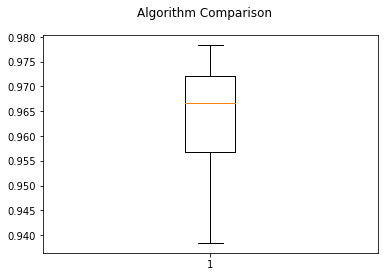

In [28]:
result = list(scores.RMSE.values)
names = list(scores.MachineLearningMethod.values)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.boxplot(result)
plt.show()

In [29]:
scores.MachineLearningMethod.values

array(['NonNegativeMatrixFactorization', 'CollaborativeFiltering', 'KNN',
       'SVD'], dtype=object)

## Apache Spark Implementation for Large Datasets

In order to run Apache Spark, pyspark must be installed. Since Apache Spark depends on Java Virtual Machines code blocks may give errors at different JVM versions. 

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

ratings_df = spark.createDataFrame(ratings)

ratings_df.head(5)

c:\users\sselamoglu\appdata\local\continuum\anaconda3\envs\deeplearn\lib\site-packages\pyspark\sql\session.py:663: UserWarning: Arrow will not be used in createDataFrame: PyArrow >= 0.8.0 must be installed; however, it was not found.
  warnings.warn("Arrow will not be used in createDataFrame: %s" % str(e))


[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182),
 Row(userId=1, movieId=1129, rating=2.0, timestamp=1260759185),
 Row(userId=1, movieId=1172, rating=4.0, timestamp=1260759205)]

In [10]:
# From ratingsDF, create a movie_ids_with_avg_ratings_df that combines the two DataFrames
movie_ids_with_avg_ratings_df = ratings_df.groupBy('movieId').agg(F.count(ratings_df.rating).alias("count"), F.avg(ratings_df.rating).alias("average"))
print('movie_ids_with_avg_ratings_df:')
movie_ids_with_avg_ratings_df.show(3, truncate=False)

movie_ids_with_avg_ratings_df:
+-------+-----+------------------+
|movieId|count|average           |
+-------+-----+------------------+
|474    |80   |3.8625            |
|2529   |57   |3.6315789473684212|
|26     |5    |4.1               |
+-------+-----+------------------+
only showing top 3 rows



### Data Seperation

In [11]:
seed = 100009193
(split_60_df, split_a_20_df, split_b_20_df) = ratings_df.randomSplit([6.0,2.0,2.0],seed)

# Let's cache these datasets for performance
training_df = split_60_df.cache()
validation_df = split_a_20_df.cache()
test_df = split_b_20_df.cache()

#print('Training: {0}, validation: {1}, test: {2}\n'.format(training_df.count(), validation_df.count(), test_df.count()))
training_df.show(3)
validation_df.show(3)
test_df.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1129|   2.0|1260759185|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
+------+-------+------+----------+
only showing top 3 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 3 rows

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|   1061|   3.0|1260759182|
|     1|   2105|   4.0|1260759139|
|     1|   2455|   2.5|1260759113|
+------+-------+------+----------+
only showing top 3 rows



### Model Training

In [12]:
from pyspark.ml.recommendation import ALS
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Let's initialize our ALS learner
als = ALS()

# Now we set the parameters for the method
als.setMaxIter(5)\
   .setSeed(seed)\
   .setRegParam(0.1)\
    .setItemCol("movieId").setUserCol("userId").setRatingCol("rating")



# Create an RMSE evaluator using the label and predicted columns
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="rmse")

tolerance = 0.03
ranks = [4, 8, 12]
errors = [0, 0, 0]
models = [0, 0, 0]
err = 0
min_error = float('inf')
best_rank = -1
for rank in ranks:
    # Set the rank here:
    als.setRank(rank)
    # Create the model with these parameters.
    model = als.fit(training_df)
    # Run the model to create a prediction. Predict against the validation_df.
    predict_df = model.transform(validation_df)

    # Remove NaN values from prediction (due to SPARK-14489)
    predicted_ratings_df = predict_df.filter(predict_df.prediction != float('nan'))

    # Run the previously created RMSE evaluator, reg_eval, on the predicted_ratings_df DataFrame
    error = reg_eval.evaluate(predicted_ratings_df)
    errors[err] = error
    models[err] = model
    print('For rank %s the RMSE is %s' % (rank, error) )
    if error < min_error:
        min_error = error
        best_rank = err
        err += 1

als.setRank(ranks[best_rank])
print('The best model was trained with rank %s' % ranks[best_rank])
my_model = models[best_rank]

For rank 4 the RMSE is 0.9428893014052406
For rank 8 the RMSE is 0.9471268801056286
For rank 12 the RMSE is 0.9504575970398356
The best model was trained with rank 4


#### Our model suggested rank 4 for least RMSE error. 

### Alternating Least Squares Prediction results for selected movies 
(Notice that Apache Spark dataframes are different from Python dataframes since they work as lazy evaluation. In order to see results, use head() function with dataframe)

In [15]:
predicted_ratings_df.head(10)

[Row(userId=232, movieId=463, rating=4.0, timestamp=955089443, prediction=3.3463611602783203),
 Row(userId=30, movieId=463, rating=4.0, timestamp=945277405, prediction=3.3719470500946045),
 Row(userId=311, movieId=463, rating=3.0, timestamp=898008246, prediction=2.776671886444092),
 Row(userId=588, movieId=471, rating=3.0, timestamp=842298526, prediction=3.37526798248291),
 Row(userId=285, movieId=471, rating=5.0, timestamp=965092130, prediction=3.89792799949646),
 Row(userId=92, movieId=471, rating=4.0, timestamp=848526594, prediction=3.9126620292663574),
 Row(userId=607, movieId=471, rating=4.0, timestamp=1118247731, prediction=2.932873487472534),
 Row(userId=23, movieId=471, rating=3.5, timestamp=1148730134, prediction=3.0091545581817627),
 Row(userId=585, movieId=471, rating=4.0, timestamp=975363578, prediction=4.160560607910156),
 Row(userId=509, movieId=471, rating=4.0, timestamp=939329728, prediction=3.2262091636657715)]